In [35]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import csv
import pyart
import subprocess
import os
import sage_data_client
import urllib
import tempfile
from xmovie import Movie
import requests
import imageio as io
import urllib
import tempfile
import datetime
import cftime
from PIL import Image
from matplotlib import image
%matplotlib inline



In [49]:
def readtofile(uurl, ff, username, password):
    r = requests.get(uurl, auth=(username,password))
    if r.status_code == 200:
        print('running')
        with open(ff, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
    
    return True

def read_mob_from_sage(url, datet):
    tempf = tempfile.NamedTemporaryFile()
    try:
        readtofile(url, tempf.name, 'waggle', '!4PublicHideMe')
        head = []
        with open(tempf.name, 'r') as f:
            reader = csv.reader(f, delimiter=';')
            for i in range(7):
                headers = next(reader)
                head.append(headers)
            _ = next(reader)
            data = np.expand_dims(np.flipud(np.array(list(reader)).astype(float)), axis=0)
        print(data.shape)
        tt = datet.to_pydatetime()
        ctime = cftime.datetime(tt.year, tt.month, tt.day, hour=tt.hour, minute=tt.minute, second=tt.second)

        ds = xr.Dataset({
        'thermalimage': xr.DataArray(
                    data   = data,   # enter data here
                    dims   = ['time', 'y', 'x'],
                    coords = {'time': [ctime],
                             'y' : np.arange(data.shape[1]),
                             'x' : np.arange(data.shape[2])},
                    attrs  = {
                        '_FillValue': -999.9,
                        'units'     : 'celsius'
                        }
                    ),
                },
            attrs = {'Source': 'MOBOTIX M16 camera operated by Sage',
                    'URL' : url}
        )
    except urllib.error.HTTPError:
        ds="ERROR"
    
    return ds

def get_latest_thermal(lookback = 2, imnum=-1):
    now = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
    an_hour_ago = (datetime.datetime.utcnow() -  \
                        datetime.timedelta(hours=lookback)).strftime('%Y-%m-%dT%H:%M:%SZ')

    df = sage_data_client.query(
        start = an_hour_ago,
        end = now, 
        filter={
            "plugin": "registry.sagecontinuum.org/bhupendraraut/mobotix-sampler.*",
            "vsn": "W057"
        }
    )

    targets = []
    times = []
    for i in range(len(df)):
        if 'celsius' in df.iloc[i].value:
            targets.append(df.iloc[i].value)
            times.append(df.iloc[i].timestamp)
    
    return read_mob_from_sage(targets[imnum], times[imnum])

def get_latest_mobvis(lookback = 2, imnum=-1):
    now = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
    an_hour_ago = (datetime.datetime.utcnow() -  \
                        datetime.timedelta(hours=lookback)).strftime('%Y-%m-%dT%H:%M:%SZ')

    df = sage_data_client.query(
        start = an_hour_ago,
        end = now, 
        filter={
            "plugin": "registry.sagecontinuum.org/bhupendraraut/mobotix-sampler.*",
            "vsn": "W057"
        }
    )

    targets = []
    times = []
    for i in range(len(df)):
        if 'jpg' in df.iloc[i].value:
            targets.append(df.iloc[i].value)
            times.append(df.iloc[i].timestamp)
    
    tempf = tempfile.NamedTemporaryFile()
    try:
        readtofile(targets[imnum], tempf.name, 'waggle', '!4PublicHideMe')
    except:
        print('oh noes')
    
    return_im = image.imread(tempf.name)
    shp = return_im.shape
    
    return return_im[:, 0:int(shp[1]/2), :]


running
(1, 252, 336)


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29918/779805687.py:24: UserWarning: Discarding nonzero nanoseconds in conversion.
  tt = datet.to_pydatetime()


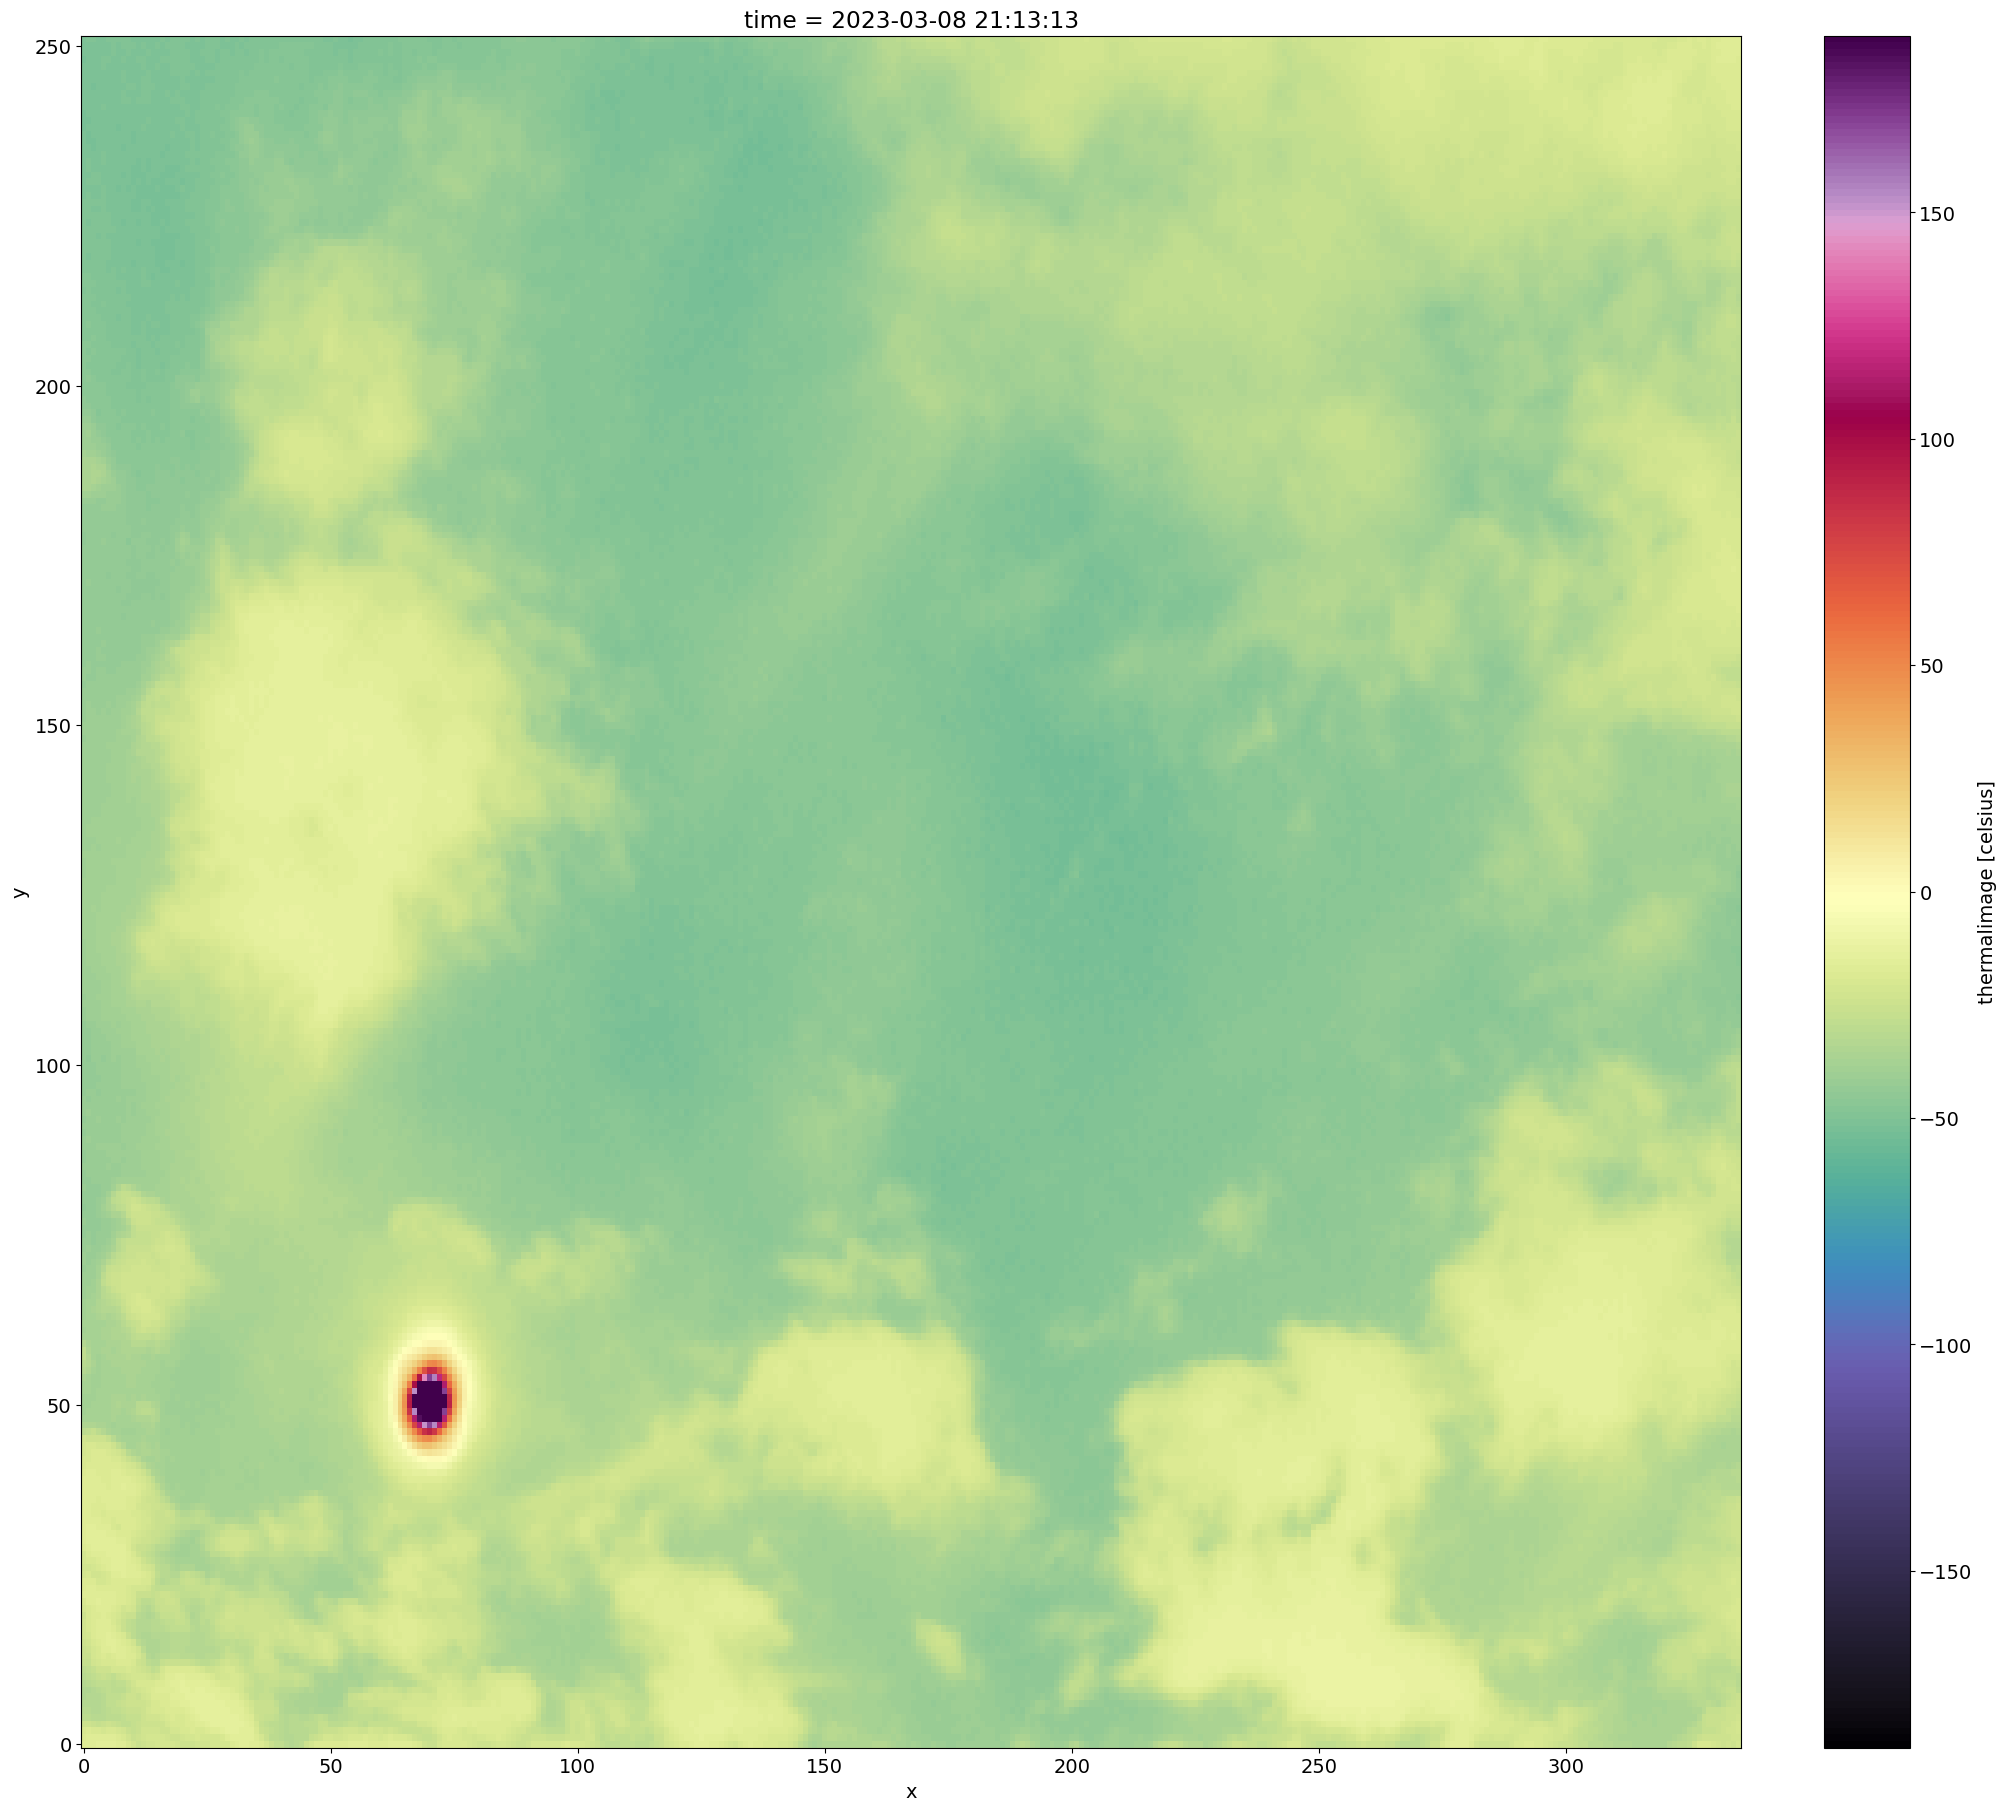

In [24]:
fig, axs = plt.subplots( ncols=1, nrows=1, figsize=[20,18], constrained_layout=True)
get_latest_thermal(lookback=2, imnum=-3).thermalimage.plot(cmap=pyart.graph.cm_colorblind.ChaseSpectral, 
                                                        ax=axs, vmin = None, vmax = None)

In [50]:
a = get_latest_mobvis()

running


In [41]:
shp = a.shape

In [43]:
shp

(2048, 6144, 3)

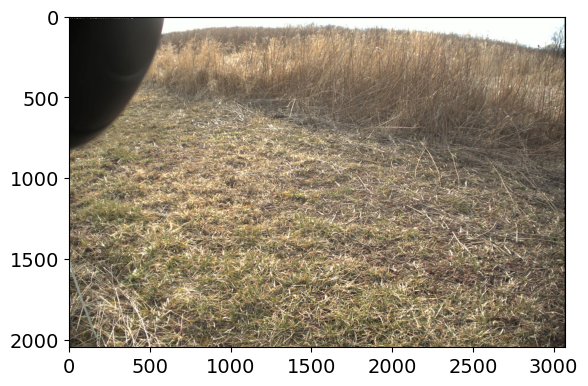

In [51]:
plt.imshow(a)

In [ ]:
ii = -12
fig, axs = plt.subplots( ncols=2, nrows=1, figsize=[25,8], constrained_layout=True)
get_latest_thermal(lookback=3, imnum=ii).thermalimage.plot(cmap=pyart.graph.cm_colorblind.ChaseSpectral, 
                                                        ax=axs[0], vmin = None, vmax = None)
axs[1].imshow(get_latest_mobvis(lookback=3, imnum=ii))

running
(1, 252, 336)


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29918/2197890573.py:24: UserWarning: Discarding nonzero nanoseconds in conversion.
  tt = datet.to_pydatetime()


running
